**Dependencies and imports**

This can take a minute...

https://arena-chapter2-rl.streamlit.app/[2.2]_Q-Learning_and_DQN

In [1]:
# https://github.com/robert-lieck/rldurham/tree/main - rldurham repo

# !pip install swig
# !pip install --upgrade rldurham
# !pip install torchinfo

In [2]:
import math
import random
import copy

import numpy as np # consider switching out for torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import rldurham as rld

# from torchinfo import summary

/Users/Subspace_Explorer/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


**Reinforcement learning agent**

NOTE - I used [this implementation](https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py) of a TD3 agent, which I informally refer to as 'Jinghao' in comments.

In [3]:
# class Agent(torch.nn.Module):
#     def __init__(self):
#         super(Agent, self).__init__()

#     def sample_action(self, s):
#         return torch.rand(act_dim) * 2 - 1 # uniform random in [-1, 1]

#     def put_data(self, action, observation, reward):
#         pass

#     def train(self):
#         pass

In [4]:
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

# helper fns

def evaluate_policy(env, agent, turns=3):
    total_scores = 0
    for i in range(turns):
        s, _ = env.reset()
        for t in range(2000): # 2000 = max_timesteps (TODO - diff from Jinghao's imp)
            # Take deterministic actions at test time
            a = agent.select_action(s, deterministic=True)
            s_next, r, dw, tr, _ = env.step(a)
            done = (dw or tr)

            total_scores += r
            s = s_next

            if done:
                break

    return int(total_scores / turns)

def adapt_reward(r):
    """Reward engineering for better training."""
    # For BipedalWalker (both versions)
    if r <= -100:
        r = -1
    return r

In [5]:
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

# agent

class ReplayBuffer():
    def __init__(self, state_dim, action_dim, max_size):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.s = torch.zeros((max_size, state_dim), dtype=torch.float)
        self.a = torch.zeros((max_size, action_dim), dtype=torch.float)
        self.r = torch.zeros((max_size, 1), dtype=torch.float)
        self.s_next = torch.zeros((max_size, state_dim), dtype=torch.float)
        self.dw = torch.zeros((max_size, 1), dtype=torch.bool)

    def add(self, s, a, r, s_next, dw):
        self.s[self.ptr] = torch.from_numpy(s)
        self.a[self.ptr] = torch.from_numpy(a) # Note that a is numpy.array
        self.r[self.ptr] = r
        self.s_next[self.ptr] = torch.from_numpy(s_next)
        self.dw[self.ptr] = dw

        self.ptr = (self.ptr + 1) % self.max_size  # Overwrite when full
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = torch.randint(0, self.size, size=(batch_size,))
        return self.s[ind], self.a[ind], self.r[ind], self.s_next[ind], self.dw[ind]


In [6]:
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

# actor and critic
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, net_width, maxaction):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, net_width)
        self.l2 = nn.Linear(net_width, net_width)
        self.l3 = nn.Linear(net_width, action_dim)
        self.maxaction = maxaction

    def forward(self, state):
        a = torch.tanh(self.l1(state))
        a = torch.tanh(self.l2(a))
        a = torch.tanh(self.l3(a)) * self.maxaction
        return a

class Double_Q_Critic(nn.Module):
    def __init__(self, state_dim, action_dim, net_width):
        super(Double_Q_Critic, self).__init__()
        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, net_width)
        self.l2 = nn.Linear(net_width, net_width)
        self.l3 = nn.Linear(net_width, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_dim + action_dim, net_width)
        self.l5 = nn.Linear(net_width, net_width)
        self.l6 = nn.Linear(net_width, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], dim=1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


In [7]:
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

class TD3_agent():
    def __init__(self, **kwargs):
        # Init hyperparameters for agent, just like "self.gamma = opt.gamma, self.lambd = opt.lambd, ..."
        self.__dict__.update(kwargs)
        self.policy_noise = 0.2 * self.max_action
        self.noise_clip = 0.5 * self.max_action
        self.tau = 0.005
        self.delay_counter = 0

        # Actor network and its target
        self.actor = Actor(self.state_dim, self.action_dim, self.net_width, self.max_action)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=self.a_lr)
        self.actor_target = copy.deepcopy(self.actor)

        # Double Q-Critic network and its target
        self.q_critic = Double_Q_Critic(self.state_dim, self.action_dim, self.net_width)
        self.q_critic_optimizer = torch.optim.Adam(self.q_critic.parameters(), lr=self.c_lr)
        self.q_critic_target = copy.deepcopy(self.q_critic)

        self.replay_buffer = ReplayBuffer(self.state_dim, self.action_dim, max_size=int(1e6))

    def select_action(self, state, deterministic):
        with torch.no_grad():
            state = torch.FloatTensor(state[np.newaxis, :]) # from [x,x,...,x] to [[x,x,...,x]]
            a = self.actor(state).cpu().numpy()[0] # from [[x,x,...,x]] to [x,x,...,x]
            if deterministic:
                return a
            else:
                noise = np.random.normal(0, self.max_action * self.explore_noise, size=self.action_dim)
                return (a + noise).clip(-self.max_action, self.max_action)

    def train(self):
        self.delay_counter += 1
        with torch.no_grad():
            s, a, r, s_next, dw = self.replay_buffer.sample(self.batch_size)

            # Compute target Q using target actor and target critic networks
            target_a_noise = (torch.randn_like(a) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            '''↓↓↓ Target Policy Smoothing Regularization ↓↓↓'''
            smoothed_target_a = (self.actor_target(s_next) + target_a_noise).clamp(-self.max_action, self.max_action)
            target_Q1, target_Q2 = self.q_critic_target(s_next, smoothed_target_a)
            '''↓↓↓ Clipped Double Q-learning ↓↓↓'''
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = r + (~dw) * self.gamma * target_Q # dw: die or win

        current_Q1, current_Q2 = self.q_critic(s, a) # Get current Q estimates

        # Compute critic loss, and optimize the q_critic
        q_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
        self.q_critic_optimizer.zero_grad()
        q_loss.backward()
        self.q_critic_optimizer.step()

        # Delayed policy updates
        '''↓↓↓ Clipped Double Q-learning ↓↓↓'''
        if self.delay_counter > self.delay_freq:
            # Update the Actor
            a_loss = -self.q_critic.Q1(s, self.actor(s)).mean()
            self.actor_optimizer.zero_grad()
            a_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            with torch.no_grad():
                for param, target_param in zip(self.q_critic.parameters(), self.q_critic_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            self.delay_counter = 0

    def save(self, EnvName, timestep):
        torch.save(self.actor.state_dict(), f"./model/{EnvName}_actor{timestep}.pth")
        torch.save(self.q_critic.state_dict(), f"./model/{EnvName}_q_critic{timestep}.pth")

    def load(self, EnvName, timestep):
        self.actor.load_state_dict(torch.load(f"./model/{EnvName}_actor{timestep}.pth"))
        self.q_critic.load_state_dict(torch.load(f"./model/{EnvName}_q_critic{timestep}.pth"))


**Prepare the environment and wrap it to capture statistics, logs, and videos**

In [8]:
# https://github.com/XinJingHao/TD3-Pytorch/blob/main/TD3.py

params = {
  'Loadmodel': False,  # Load pretrained model or Not
  'ModelIdex': 30,  # Which model to load
  'update_every' : 50,  # Training frequency
  'save_interval' : int(1e5),  # Model saving interval, in steps
  'eval_interval' : int(2e3),  # Model evaluating interval, in steps
  'delay_freq' : 1,  # Delayed frequency for Actor and Target Net
  'gamma' : 0.99,  # Discounted Factor
  'net_width' : 256,  # Hidden net width
  'a_lr' : 1e-4,  # Learning rate of actor
  'c_lr' : 1e-4,  # Learning rate of critic
  'batch_size' : 256,  # Batch size for training
  'explore_noise' : 0.15,  # Exploring noise when interacting
  'explore_noise_decay' : 0.998,  # Decay rate of explore noise
}

/Users/Subspace_Explorer/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/Subspace_Explorer/Documents/Programming/RL-coursework/nchw73/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


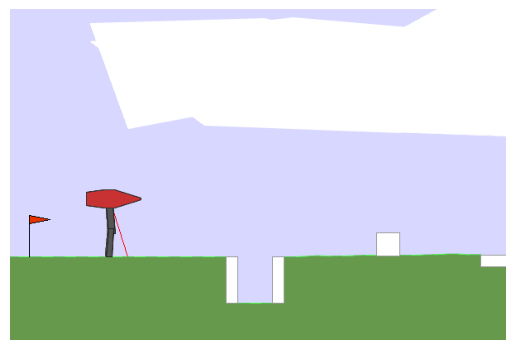

In [ ]:
hardcore = False

if hardcore == False:
  env = rld.make("rldurham/Walker", render_mode="rgb_array")
  eval_env = rld.make("rldurham/Walker", render_mode="rgb_array") # TODO Jinghao - maybe necessary to eval policy w/o noise?
else:
  env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version
  eval_env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True)

# get statistics, logs, and videos
if hardcore:
    vid_prefix = "nchw73-agent-hardcore-video"
else:
    vid_prefix = "nchw73-agent-video"
    
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix=vid_prefix,  # prefix for videos
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)
params['max_action'] = float(env.action_space.high[0]) # Jinghao: this is used to scale the agent's actions to ensure they stay in action space

# render start image
env.reset(seed=42)
rld.render(env)

**Training**

In [10]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

max_episodes = 1000
max_timesteps = 2000 # DO NOT CHANGE
max_total_steps = max_episodes * max_timesteps
warm_up_steps = 10 * max_timesteps # TODO adjust this to need

# for Jinghao format TODO change
params['state_dim'] = obs_dim
params['action_dim'] = act_dim

# track statistics for plotting
tracker = rld.InfoTracker()

is_recording = False
env.video = False # switch video recording off (only switch on every x episodes as this is slow)

# initialise agent
agent = TD3_agent(**params) # ** unpacks the dictionary into keyword arguments
# summary(agent) # torchinfo for parameter breakdown

Seed set to 42


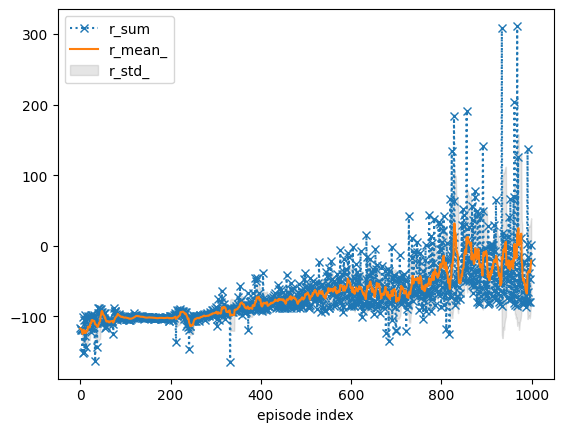

In [11]:
# training procedure
total_steps = 0
test = True
for episode in range(max_episodes):

    # recording statistics and video can be switched on and off (video recording is slow!)
    if is_recording: # generally get good results after ep 500 on easy
        env.info = episode % 10 == 0   # track every x episodes (usually tracking every episode is fine)
        env.video = episode % 10 == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()

    # run episode
    for t in range(max_timesteps):

        # select the agent action
        if total_steps < warm_up_steps: # warm up period for first x% of steps (NOTE - different to Jinghao imp) TODO check this helps
            if not test:
                print('warm up... again???')
            action = env.action_space.sample() # random actions
        else:
            if test:
              print('warm up over!')
              test = False
            # action = agent.sample_action(observation)
            action = agent.select_action(observation, deterministic=False) # Jinghao TODO

        # take action in the environment
        next_observation, reward, terminated, truncated, info = env.step(action)

        reward = adapt_reward(reward) # Jinghao

        # remember
        # agent.put_data(action, observation, reward)
        agent.replay_buffer.add(observation, action, reward, next_observation, terminated) # Jinghao todo

        observation = next_observation # TODO necessary if its just reset next ep?

        total_steps += 1

        # check whether done
        done = terminated or truncated

        # TRAIN THE AGENT HERE!
        # TODO Jinghao does this as follows in the loop, but template trains after each ep
        # Train every 'update_every' steps after an initial period
        if (episode >= 1) and (total_steps % params['update_every'] == 0):
            for _ in range(params['update_every']):
                agent.train()

        # stop episode
        if done:
            break

    # Evaluate policy after each episode (TODO Jinghao - JH imp does this every 2000 steps (hyperparam), not necc after each ep)
    agent.explore_noise *= params['explore_noise_decay']
    ep_reward = evaluate_policy(eval_env, agent, turns=3)
    print(f'Ep: {episode}, Steps: {total_steps//1000}k, Episode Reward: {ep_reward}')

    # track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()
eval_env.close()

# write log file (for coursework)
if hardcore:
    filename = "nchw73-agent-hardcore-log.txt"
else:
    filename = "nchw73-agent-log.txt"
env.write_log(folder="logs", file=filename)


##  Demo

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [12]:
# from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

# env = rld.make(
#     "rldurham/Walker",
#     # "BipedalWalker-v3",
#     render_mode="human",
#     # render_mode="rgb_array",
#     hardcore=False,
#     # hardcore=True,
# )
# _, obs, info = rld.seed_everything(42, env)
# # track statistics for plotting
# tracker2 = rld.InfoTracker()

# heuristics = BipedalWalkerHeuristics()

# act = heuristics.step_heuristic(obs)
# for i in range(500):
#     obs, rew, terminated, truncated, info = env.step(act)
#     act = heuristics.step_heuristic(obs)
#     if terminated or truncated:
#         break
#     if env.render_mode == "rgb_array":
#         rld.render(env, clear=True)

#     # track and plot statistics
#     tracker2.track(info)
#     if (i + 1) % 10 == 0:
#         tracker2.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))
# env.close()